In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mpmath import mp, findroot, j
from mpmath import cosh, sinh, tanh, exp, sqrt

In [3]:
from scipy.optimize import curve_fit

In [4]:
from gwr_inversion import gwr

In [5]:
import time

In [6]:
## Functions and expressions declarations
def decaying_sinusoid(t, om_dec, om_osc):
    return np.exp(- om_dec * t)*np.cos(om_osc * t)

def my_exp(t, om_dec):
      return np.exp(- om_dec * t)

def better_sinusoid(t, om_dec, om_osc, amp, phi):
    return amp*np.exp(- om_dec * t)*np.cos(om_osc * t + phi)

def shifted_sinusoid(t, om_dec, om_osc, phi):
    return np.exp(- om_dec * t)*np.cos(om_osc * t + phi)

In [7]:
#Declare the expressions of the kernel and eta
def ker_sy (s, Oh, Bo, k, lbda):
    return 2*Oh/s*k*(k-lbda*tanh(k)) - Oh/s*(4*lbda*k*sinh(k)*(k*exp(-lbda)
            *(k*cosh(k)+lbda*sinh(k))-(k**2+lbda**2))+(k**2+lbda**2)**2
            *sinh(lbda))/(2*k*cosh(k)*(k*cosh(k)*sinh(lbda)-lbda*sinh(k)*cosh(lbda)))
            
def eta_sy (s, Oh, k, omega2, Kern):
    return 1/s*(1-omega2/(s**2+4*Oh*k**2*s+omega2+2*Oh*k**2*s*Kern))

In [8]:
#Reduce the expressions as functions of s and of the parameters Oh, Bo and k
def freeSurfaceLaplace(s, Oh, Bo, k):
    lbda = sqrt(k**2 + s/Oh)
    omega2 = (Bo+k**2)*k*tanh(k)
    ker = ker_sy (s, Oh, Bo, k, lbda)
    return eta_sy(s, Oh, k, omega2, ker)

In [9]:
#Inverse the Laplace transfrom and return the values of eta as a function 
#of a range of t and the parameters Oh, Bo and k
def freeSurface(t_all, Ohnumb, Bonumb, knumb, M_value = 32):
    store = time.time()
    Oh = mp.mpmathify(Ohnumb)
    Bo = mp.mpmathify(Bonumb)
    k = mp.mpmathify(knumb) 
    f = lambda s: freeSurfaceLaplace(s, Oh, Bo, k)
    a = [float(gwr(f, t, M_value)) for t in t_all]
    print (time.time()-store)
    return a

In [10]:
def pulsation(Bo, k):
    return np.sqrt(np.abs(Bo + k**2)*k*np.tanh(k))

In [11]:
#Asymptotic solutions obtained from the normal mode in Cortelezzi's derivation
def om_normal_mode_viscous(Oh, Bo, k):
    return -pulsation(Bo, k)**2/(k**2*Oh*np.tanh(k))*(k-np.cosh(k)*np.sinh(k))/(1+2*k**2+np.cosh(2*k))
    
def puls_normal_mode_inertial(Oh, Bo, k):
    return pulsation(Bo, k) - (1/np.sinh(2*k)*np.sqrt(pulsation(Bo, k) * k**2*Oh/2)
            - pow(k**2*Oh,3./2.)/np.sqrt(2*pulsation(Bo, k))
            *(3-8*np.cosh(2*k)-14*np.cosh(4*k)+4*np.cosh(6*k))/(8*np.sinh(2*k)**3)) 

def om_normal_mode_inertial(Oh, Bo, k):
    return (1/np.sinh(2*k)*np.sqrt(pulsation(Bo, k) * k**2*Oh/2) +
            2*k**2*Oh * (np.cosh(4*k)+np.cosh(2*k)-1) / (np.cosh(4*k) -1)
            - pow(k**2*Oh,3./2.)/np.sqrt(2*pulsation(Bo, k))
            *(3-8*np.cosh(2*k)-14*np.cosh(4*k)+4*np.cosh(6*k))/(8*np.sinh(2*k)**3)) 

In [12]:
#Growth rate and pulsations obtained by fit of the numerical solution.
def om_numerical(Oh, Bo, k, guess_value=()):
    if not any(guess_value): # empty guess value: this is the first iteration
        if (Oh < pulsation(Bo, k)/(k**2/0.7+1/0.6)): # inertial case
            om_0 = puls_normal_mode_inertial(Oh, Bo, k) 
            om_relax = om_normal_mode_inertial(Oh, Bo, k)
        else:
            om_relax = om_normal_mode_viscous(Oh, Bo, k)
            om_0 = om_relax
        guess_value = (om_relax, om_0, 1., np.pi/4.)
    M = 64
    om_relax = guess_value[0]
    om_0 = guess_value[1]
    t_all = np.linspace(0.01, 1., 100) * min(10./om_0, abs(10./om_relax))
#    om_0 = puls_normal_mode_inertial(Oh, Bo, k) # valid only in the inertial zone
#    if (Oh < pulsation(Bo, k)/(k**2/0.7+1/0.6)): 
#        M = 64
#        om_relax = om_normal_mode_inertial(Oh, Bo, k)
#        t_all = np.linspace(0.01, 1., 100) * min(10./om_0, abs(10./om_relax)) 
#    else:
#        M = 32
#        om_relax = om_normal_mode_viscous(Oh, Bo, k)
#        t_all = np.linspace(0.01, 1., 100) * abs(10./om_relax)
#        om_0 = om_relax
    sampled_eta = freeSurface(t_all, Oh, Bo, k, M)
    if True:
        # let's find out if there is an oscillation
#        underwater = np.where(np.array(sampled_eta) < 0.)[0]
#        if underwater.size == 0: # then there is no oscillation
#            left_window = 0
#        else: # here there is one. Let's start the fit at 1/8th of the first period, to get rid of transients
#            left_window = np.ceil((underwater[0])/2.).astype(int)
#        after_transient = np.where(np.array(sampled_eta) < 0.5)[0]
#        left_window = after_transient[0]
#        transient_timescale = t_all[left_window]
#        print("left_window = ", left_window)
#        print("transient_timescale = ", transient_timescale)
#        popt_alt = curve_fit(decaying_sinusoid, t_all, sampled_eta, p0=(om_relax, om_0), bounds=(0,[np.inf, 5*om_0]))[0]
#        popt = curve_fit(better_sinusoid, t_all[left_window:], sampled_eta[left_window:], p0=(om_relax, om_0, 1., np.pi/4), bounds=(0,[np.inf, 5*om_0, 5., 2.*np.pi]))[0]
#        popt_shift = curve_fit(better_sinusoid, t_all, sampled_eta, p0=(om_relax, om_0, 1., np.pi/4.), bounds=(0,[np.inf, 5*om_0, 5., 2.*np.pi]), sigma=np.exp(-om_relax*t_all))[0]
#        popt_shift = curve_fit(better_sinusoid, t_all, sampled_eta, p0=(173.03456765, 201.51031896,   1.26683438,   5.8649423), bounds=(0,[np.inf, 5*om_0, 5., 2.*np.pi]), sigma=1e-6+np.exp(-t_all/transient_timescale))[0]
#        popt_shift = curve_fit(better_sinusoid, t_all, sampled_eta, p0=(om_relax, om_0, 1., np.pi/4.), bounds=(0,[np.inf, 5.*om_0, 5., 2.*np.pi]), sigma=(0.05+np.exp(-t_all/transient_timescale)))[0]
#        popt_shift = curve_fit(better_sinusoid, t_all, sampled_eta, p0=(om_relax, om_0, 1., np.pi/4.), bounds=(0,[np.inf, 5.*om_0, 5., 2.*np.pi]), sigma=1./(1.+om_relax*t_all))[0]
        popt = curve_fit(better_sinusoid, t_all, sampled_eta, p0=guess_value, bounds=(0,[np.inf, 5*om_0, 5., 2.*np.pi]), sigma=np.exp(-om_relax*t_all))[0]
#        print ("om_relax = ", om_relax)
#        print ("om_normal_mode_viscous(Oh, Bo, k) = ", om_normal_mode_viscous(Oh, Bo, k))
    else:
        popt = [curve_fit(my_exp, t_all, sampled_eta, p0=(om_relax))[0][0], 0]
    return popt, t_all, sampled_eta

5.83680272102356
left_window =  10
transient_timescale =  0.0030816839827752466
om_relax =  21.67639737482949
om_normal_mode_viscous(Oh, Bo, k) =  5001.999999999998


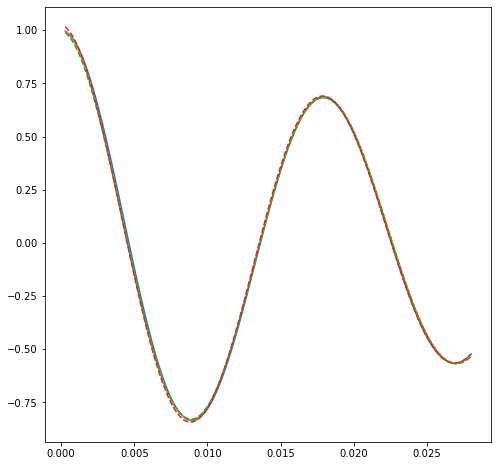

In [447]:
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(5e-3, 1, 5e1)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
plt.plot(sampled_t, eta_fit, '--')
plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '--')
plt.savefig("Oh5e-3_k_5e1.png")
plt.show()

In [336]:
params_shift

array([2.21238105e+01, 3.48096019e+02, 1.02785134e+00, 6.79371767e-25])

In [137]:
params_alt

array([ 20.80478043, 346.8504177 ])

1.849440097808838
left_window =  11
transient_timescale =  0.004798080767692924
om_relax =  250.09999999999994
om_normal_mode_viscous(Oh, Bo, k) =  250.09999999999994


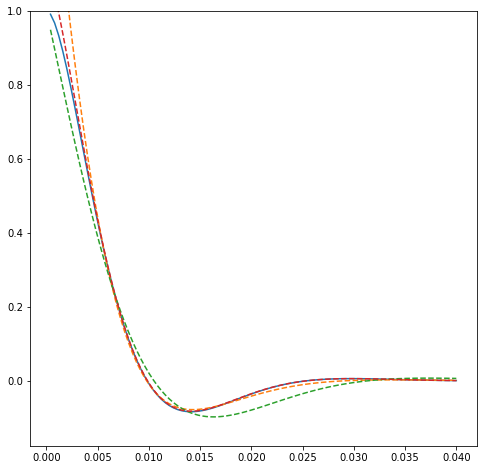

In [458]:
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(1e-1, 1, 5e1)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
plt.plot(sampled_t, eta_fit, '--')
plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '--')
ax = plt.gca()
ax.set_ylim([None,1.0])
plt.savefig("Oh1e-1_k_5e1.png")
plt.show()

In [454]:
params_shift

array([173.03456765, 201.51031896,   1.26683438,   5.8649423 ])

In [449]:
params_shift

array([1.75538347e+02, 1.87797770e+02, 1.32353898e+00, 4.35124651e-19])

2.180026054382324
left_window =  7
transient_timescale =  0.0063974410235905655
om_relax =  125.04999999999997
om_normal_mode_viscous(Oh, Bo, k) =  125.04999999999997


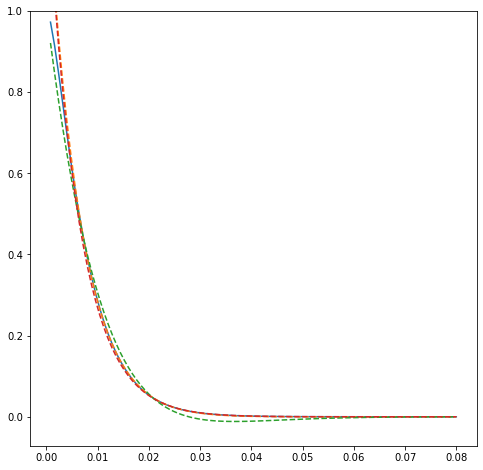

In [435]:
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(2e-1, 1, 5e1)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
plt.plot(sampled_t, eta_fit, '--')
plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '--')
ax = plt.gca()
ax.set_ylim([None,1.0])
plt.savefig("Oh2e-1_k_5e1.png")
plt.show()

In [275]:
params_shift

array([1.56783351e+02, 1.85274186e+01, 1.30489002e+00, 1.30801633e-14])

In [282]:
params_shift

array([1.56783338e+02, 1.85274276e+01, 1.30488987e+00, 9.75892135e-16])

In [187]:
params #1/100

array([1.50698542e+02, 1.54486600e+02, 1.18883234e+00, 1.23326397e-25])

In [178]:
params #1/4

array([1.68170653e+02, 1.58134121e+02, 1.36355644e+00, 6.33133210e-24])

In [181]:
params #1/2

array([1.84299583e+02, 1.61184055e+02, 1.63307378e+00, 5.72908130e-20])

In [184]:
params #1

array([2.23894860e+02, 1.58942190e+02, 3.14786247e+00, 1.14473965e-22])

1.9471180438995361
left_window =  6
transient_timescale =  0.1399440223910436
om_relax =  5.001999999999999
om_normal_mode_viscous(Oh, Bo, k) =  5.001999999999999


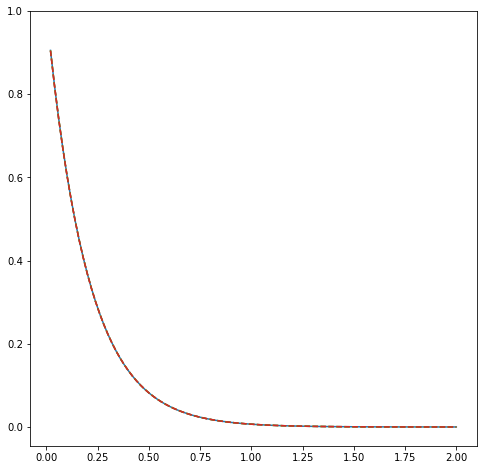

In [436]:
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(5e0, 1, 5e1)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
plt.plot(sampled_t, eta_fit, '--')
plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '--')
ax = plt.gca()
ax.set_ylim([None,1.0])
plt.savefig("Oh5e0_k_5e1.png")
plt.show()

5.097625970840454
left_window =  10
transient_timescale =  24.88947824768451
om_relax =  0.007123312138710409
om_normal_mode_viscous(Oh, Bo, k) =  0.1663348738777257


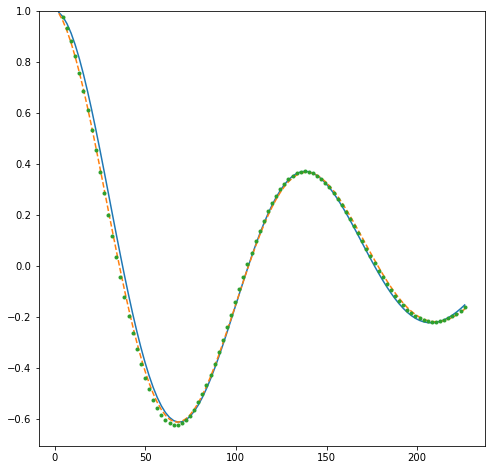

In [437]:
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(5e-3, 1, 5e-2)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
plt.plot(sampled_t, eta_fit, '--')
#plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '.')
ax = plt.gca()
ax.set_ylim([None,1.0])
plt.savefig("Oh5e-3_k_5e-2.png")
plt.show()

1.7107090950012207
left_window =  9
transient_timescale =  36.07181019904854
om_relax =  0.027722478979620952
om_normal_mode_viscous(Oh, Bo, k) =  0.027722478979620952


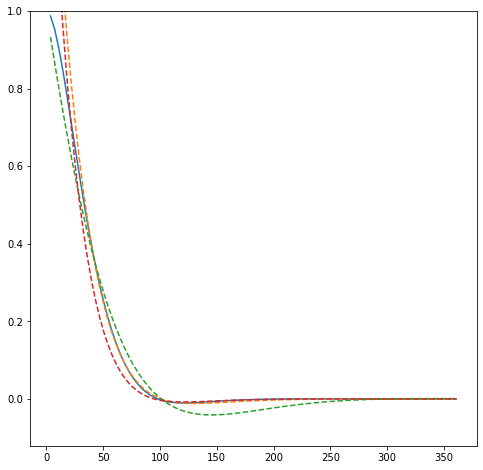

In [445]:
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(3e-2, 1, 5e-2)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
plt.plot(sampled_t, eta_fit, '--')
plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '--')
ax = plt.gca()
ax.set_ylim([None,1.0])
plt.savefig("Oh3e-2_k_5e-2.png")
plt.show()

In [405]:
params

array([3.21063982e-02, 1.55431825e-02, 1.74349520e+00, 2.90204618e-15])

In [417]:
params_shift

array([2.97403513e-02, 1.49117584e-02, 1.37752694e+00, 1.05699807e-21])

1.984154224395752
left_window =  2
transient_timescale =  360.7181019904855
om_relax =  0.0008316743693886284
om_normal_mode_viscous(Oh, Bo, k) =  0.0008316743693886284


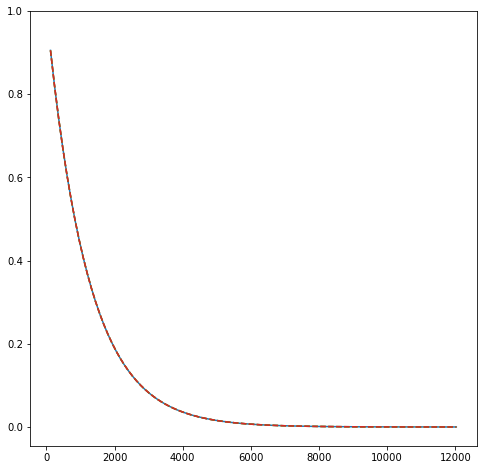

In [351]:
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(1, 1, 5e-2)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
plt.plot(sampled_t, eta_fit, '--')
plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '--')
ax = plt.gca()
ax.set_ylim([None,1.0])
plt.savefig("Oh1e0_k_5e-2.png")
plt.show()

In [300]:
params_shift

array([8.31920015e-04, 3.11966298e-07, 1.00489273e+00, 9.53151091e-02])

In [100]:
x = np.array([1, 2, 3, 1, 0, 10, 7])

In [103]:
np.where(x<0)[0].size

0

In [96]:
x[[3,5]]

array([ -1, -10])

In [98]:
x[np.where(x<0)[0]]

array([ -1, -10])

In [109]:
x[np.ceil(1.2).astype(int)]

3

In [108]:
ceiling=np.array(dtype=int64)

NameError: name 'int64' is not defined

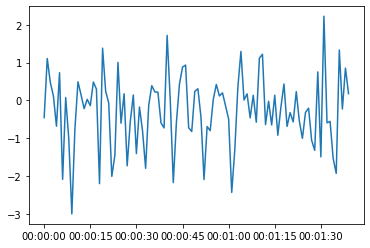

In [464]:
import pandas as pd
import numpy as np
import time
from IPython import display
i = pd.date_range('2013-1-1',periods=100,freq='s')

while True:
    try:
        plt.clf()
        plt.plot(pd.Series(data=np.random.randn(100), index=i))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)
    except KeyboardInterrupt:
        break

/Users/antko/anaconda3/lib/python3.9/site-packages/matplotlib/animation.py:973: UserWarning: Animation was deleted without rendering anything. This is most likely unintended. To prevent deletion, assign the Animation to a variable that exists for as long as you need the Animation.
  warnings.warn(


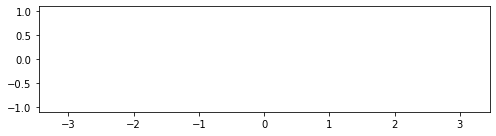

In [466]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(7, 2))
ax = plt.subplot()

X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
C, S = np.cos(X), np.sin(X)
(line1,) = ax.plot(X, C, marker="o", markevery=[-1], markeredgecolor="white")
(line2,) = ax.plot(X, S, marker="o", markevery=[-1], markeredgecolor="white")


def update(frame):
    line1.set_data(X[:frame], C[:frame])
    line2.set_data(X[:frame], S[:frame])


plt.tight_layout()
ani = animation.FuncAnimation(fig, update, interval=10)
plt.savefig("sine-cosine.pdf")
plt.show()

  0%|          | 0/256 [00:00<?, ?it/s]

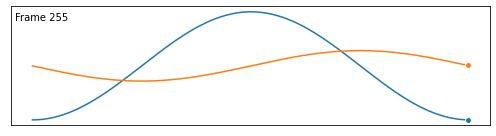

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure(figsize=(7, 2))
ax = plt.subplot()

X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
C, S = np.cos(X), np.sin(X)
(line1,) = ax.plot(X, C, marker="o", markevery=[-1], markeredgecolor="white")
(line2,) = ax.plot(X, S, marker="o", markevery=[-1], markeredgecolor="white")
text = ax.text(0.01, 0.95, "Test", ha="left", va="top", transform=ax.transAxes)
ax.set_xticks([])
ax.set_yticks([])


def update(frame):
    line1.set_data(X[:frame], (1.+frame/100.)*C[:frame])
    line2.set_data(X[:frame], S[:frame])
    text.set_text("Frame %d" % frame)
#    ax.set_autoscale_on(True)
    ax.relim()
    ax.autoscale_view(True, True, True)
    if frame in [1, 32, 128, 255]:
        plt.savefig("sine-cosine-frame-%03d.pdf" % frame)
    return line1, line2, text


plt.tight_layout()
writer = animation.FFMpegWriter(fps=30)
anim = animation.FuncAnimation(fig, update, interval=10, frames=len(X),blit=True)
from tqdm.autonotebook import tqdm

bar = tqdm(total=len(X))
anim.save(
    "sine-cosine.mp4",
    writer=writer,
    dpi=100,
    progress_callback=lambda i, n: bar.update(1),
)
bar.close()

1.7866146564483643
left_window =  11
transient_timescale =  0.004798080767692924
om_relax =  250.09999999999994
om_normal_mode_viscous(Oh, Bo, k) =  250.09999999999994


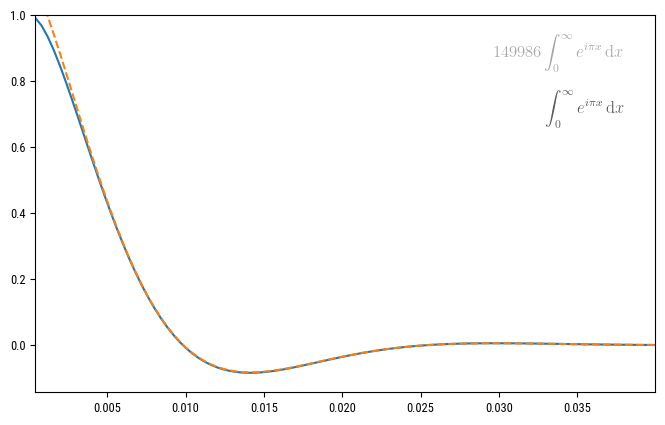

In [518]:
import matplotlib 
plt.rcParams.update({"text.usetex": False})
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(1e-1, 1, 5e1)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8, 5), dpi=100)
ax = plt.subplot(1, 1, 1)
#plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
#plt.plot(sampled_t, eta_fit, '--')
#plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '--')
font = matplotlib.font_manager.FontProperties(
    family="Roboto Condensed", weight="regular", size=9
)
ax = plt.gca()
ax.set_ylim([None,1.0])
for label in ax.get_xticklabels():
    label.set_size(9)
    label.set_fontproperties(font)
for label in ax.get_yticklabels():
    label.set_size(9)
    label.set_fontproperties(font)
bidule = 149986.001432
ax.text(
    0.95,
    0.9,
    r"$${0:g} \int_0^\infty e^{{i \pi x}}\,\mathrm dx$$".format(bidule),
    size=12,
    color=".65",
    usetex= True,
    horizontalalignment="right",
    verticalalignment="center", transform=ax.transAxes
)
ax.text(
    0.95,
    0.75,
    r"$$\int_0^\infty e^{{i \pi x}}\,\mathrm dx$$".format(bidule),
    size=12,
    color=".35",
    usetex= True,
    horizontalalignment="right",
    verticalalignment="center", transform=ax.transAxes
)
#plt.tight_layout()
ax.autoscale(enable=True, axis='x', tight=True)
plt.savefig("Oh1e-1_k_5e1.png")
plt.show()

In [15]:
def test_func(x, guess_value=()):
    print ("x = ", x)
    print ("len(*args) = ", len(guess_value))

In [19]:
test_func(1, "a")

x =  1
len(*args) =  1


In [ ]:
def movie_fit(Oh_params, k_params):
    scan_points
        get_data
        update_fig
        push_in_movie

In [23]:
for number in np.logspace(-3,-1,7):
    print(number)

0.001
0.0021544346900318843
0.004641588833612777
0.01
0.021544346900318832
0.046415888336127774
0.1


In [29]:
import itertools
for glou in itertools.product([1.,2.],[0.001,0.1]):
    print(glou)

(1.0, 0.001)
(1.0, 0.1)
(2.0, 0.001)
(2.0, 0.1)


In [30]:
from dataclasses import dataclass

@dataclass
class Point:
    x: float
    y: float
    z: float = 0.0


p = Point(1.5, 2.5)

print(p)  # Point(x=1.5, y=2.5, z=0.0)

Point(x=1.5, y=2.5, z=0.0)


In [39]:
from dataclasses import dataclass

@dataclass
class Params:
    start_log: float
    stop_log: float
    npts: int


glou = Params(1., 2, 3)
Ohprms = Params(-3., -1., 5)
kprms = Params(-1., -1., 1)
print(glou)  # Point(x=1.5, y=2.5, z=0.0)

Params(start_log=1.0, stop_log=2, npts=3)


In [35]:
type(glou.stop_log)

int

In [36]:
def build_phase_diagram_scanner(Oh_params, k_params):
    Oh_points = np.logspace(Oh_params.start_log, Oh_params.stop_log, Oh_params.npts)
    k_points  = np.logspace(k_params.start_log, k_params.stop_log, k_params.npts)
    phase_diagram_pts = itertools.product(Oh_points, k_points)
    return phase_diagram_pts

In [40]:
dist_func(Ohprms,kprms)

(0.001, 0.1)
(0.0031622776601683794, 0.1)
(0.01, 0.1)
(0.03162277660168379, 0.1)
(0.1, 0.1)


In [41]:
tpl = (1, 2.)

In [42]:
tpl[0]

1

In [ ]:
plt.rcParams.update({"text.usetex": False})
params, params_alt, params_shift, sampled_t, sampled_eta = om_numerical(1e-1, 1, 5e1)
eta_fit = better_sinusoid(sampled_t, *params)
eta_fit_alt = decaying_sinusoid(sampled_t, *params_alt)
eta_fit_shift = better_sinusoid(sampled_t, *params_shift)
plt.figure(figsize=(8, 5), dpi=100)
ax = plt.subplot(1, 1, 1)
#plt.figure(figsize=(8,8))
plt.plot(sampled_t, sampled_eta)
#plt.plot(sampled_t, eta_fit, '--')
#plt.plot(sampled_t, eta_fit_alt, '--')
plt.plot(sampled_t, eta_fit_shift, '--')
font = matplotlib.font_manager.FontProperties(
    family="Roboto Condensed", weight="regular", size=9
)
ax = plt.gca()
ax.set_ylim([None,1.0])
for label in ax.get_xticklabels():
    label.set_size(9)
    label.set_fontproperties(font)
for label in ax.get_yticklabels():
    label.set_size(9)
    label.set_fontproperties(font)
bidule = 149986.001432
ax.text(
    0.95,
    0.9,
    r"$${0:g} \int_0^\infty e^{{i \pi x}}\,\mathrm dx$$".format(bidule),
    size=12,
    color=".65",
    usetex= True,
    horizontalalignment="right",
    verticalalignment="center", transform=ax.transAxes
)
ax.text(
    0.95,
    0.75,
    r"$$\int_0^\infty e^{{i \pi x}}\,\mathrm dx$$".format(bidule),
    size=12,
    color=".35",
    usetex= True,
    horizontalalignment="right",
    verticalalignment="center", transform=ax.transAxes
)
#plt.tight_layout()
ax.autoscale(enable=True, axis='x', tight=True)
plt.savefig("Oh1e-1_k_5e1.png")
plt.show()

In [86]:
tpl = itertools.product([1.,2.,3.],[0.001,0.1])

In [54]:
print(np.fromiter(tpl,dtype=float))

[]


In [75]:
tbl=np.array(list(tpl))

In [78]:
print(tbl.reshape(3,2,2))

[[[1.e+00 1.e-03]
  [1.e+00 1.e-01]]

 [[2.e+00 1.e-03]
  [2.e+00 1.e-01]]

 [[3.e+00 1.e-03]
  [3.e+00 1.e-01]]]


In [79]:
7 % 3

1

In [80]:
8 % 3

2

In [81]:
9 % 3

0

In [82]:
tbl

array([[1.e+00, 1.e-03],
       [1.e+00, 1.e-01],
       [2.e+00, 1.e-03],
       [2.e+00, 1.e-01],
       [3.e+00, 1.e-03],
       [3.e+00, 1.e-01]])

In [92]:
tpl = itertools.product([1.,2.,3.],[0.001,0.1])

In [93]:
for _ in tpl:
    print(_[0])

1.0
1.0
2.0
2.0
3.0
3.0


In [91]:
next(tpl)

StopIteration: 

In [108]:
not any(np.array([1]))

False

In [104]:
om_numerical(5e-3, 1, 5e1)

5.147782802581787


(array([2.17955883e+01, 3.47241280e+02, 1.01775223e+00, 1.32424469e-17]),
 array([0.00028015, 0.00056031, 0.00084046, 0.00112061, 0.00140077,
        0.00168092, 0.00196107, 0.00224122, 0.00252138, 0.00280153,
        0.00308168, 0.00336184, 0.00364199, 0.00392214, 0.0042023 ,
        0.00448245, 0.0047626 , 0.00504276, 0.00532291, 0.00560306,
        0.00588321, 0.00616337, 0.00644352, 0.00672367, 0.00700383,
        0.00728398, 0.00756413, 0.00784429, 0.00812444, 0.00840459,
        0.00868475, 0.0089649 , 0.00924505, 0.00952521, 0.00980536,
        0.01008551, 0.01036566, 0.01064582, 0.01092597, 0.01120612,
        0.01148628, 0.01176643, 0.01204658, 0.01232674, 0.01260689,
        0.01288704, 0.0131672 , 0.01344735, 0.0137275 , 0.01400765,
        0.01428781, 0.01456796, 0.01484811, 0.01512827, 0.01540842,
        0.01568857, 0.01596873, 0.01624888, 0.01652903, 0.01680919,
        0.01708934, 0.01736949, 0.01764964, 0.0179298 , 0.01820995,
        0.0184901 , 0.01877026, 0.01905041

In [106]:
tuple(np.array([2.17955883e+01, 3.47241280e+02, 1.01775223e+00, 1.32424469e-17]))

(21.7955883, 347.24128, 1.01775223, 1.32424469e-17)

# Phase diagram scan

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
from mpmath import mp, findroot, j
from mpmath import cosh, sinh, tanh, exp, sqrt
from gwr_inversion import gwr
from scipy.optimize import curve_fit

In [3]:
from dataclasses import dataclass # to build struct like objects. Requires Python 3.7. We could use tuples instead
import itertools

In [4]:
import time
import matplotlib.animation as animation

In [5]:
@dataclass
class Params:
    start_log: float
    stop_log: float
    npts: int

In [6]:
## Functions and expressions declarations

def better_sinusoid(t, om_dec, om_osc, amp, phi):
    return amp*np.exp(- om_dec * t)*np.cos(om_osc * t + phi)

In [7]:
#Declare the expressions of the kernel and eta
def ker_sy (s, Oh, Bo, k, lbda):
    return 2*Oh/s*k*(k-lbda*tanh(k)) - Oh/s*(4*lbda*k*sinh(k)*(k*exp(-lbda)
            *(k*cosh(k)+lbda*sinh(k))-(k**2+lbda**2))+(k**2+lbda**2)**2
            *sinh(lbda))/(2*k*cosh(k)*(k*cosh(k)*sinh(lbda)-lbda*sinh(k)*cosh(lbda)))
            
def eta_sy (s, Oh, k, omega2, Kern):
    return 1/s*(1-omega2/(s**2+4*Oh*k**2*s+omega2+2*Oh*k**2*s*Kern))

In [8]:
#Reduce the expressions as functions of s and of the parameters Oh, Bo and k
def freeSurfaceLaplace(s, Oh, Bo, k):
    lbda = sqrt(k**2 + s/Oh)
    omega2 = (Bo+k**2)*k*tanh(k)
    ker = ker_sy (s, Oh, Bo, k, lbda)
    return eta_sy(s, Oh, k, omega2, ker)

In [9]:
#Inverse the Laplace transfrom and return the values of eta as a function 
#of a range of t and the parameters Oh, Bo and k
def freeSurface(t_all, Ohnumb, Bonumb, knumb, M_value = 32):
    store = time.time()
    Oh = mp.mpmathify(Ohnumb)
    Bo = mp.mpmathify(Bonumb)
    k = mp.mpmathify(knumb) 
    f = lambda s: freeSurfaceLaplace(s, Oh, Bo, k)
    a = [float(gwr(f, t, M_value)) for t in t_all]
    print (time.time()-store)
    return a

In [10]:
def pulsation(Bo, k):
    return np.sqrt(np.abs(Bo + k**2)*k*np.tanh(k))

In [11]:
#Asymptotic solutions obtained from the normal mode in Cortelezzi's derivation
def om_normal_mode_viscous(Oh, Bo, k):
    return -pulsation(Bo, k)**2/(k**2*Oh*np.tanh(k))*(k-np.cosh(k)*np.sinh(k))/(1+2*k**2+np.cosh(2*k))
    
def puls_normal_mode_inertial(Oh, Bo, k):
    return pulsation(Bo, k) - (1/np.sinh(2*k)*np.sqrt(pulsation(Bo, k) * k**2*Oh/2)
            - pow(k**2*Oh,3./2.)/np.sqrt(2*pulsation(Bo, k))
            *(3-8*np.cosh(2*k)-14*np.cosh(4*k)+4*np.cosh(6*k))/(8*np.sinh(2*k)**3)) 

def om_normal_mode_inertial(Oh, Bo, k):
    return (1/np.sinh(2*k)*np.sqrt(pulsation(Bo, k) * k**2*Oh/2) +
            2*k**2*Oh * (np.cosh(4*k)+np.cosh(2*k)-1) / (np.cosh(4*k) -1)
            - pow(k**2*Oh,3./2.)/np.sqrt(2*pulsation(Bo, k))
            *(3-8*np.cosh(2*k)-14*np.cosh(4*k)+4*np.cosh(6*k))/(8*np.sinh(2*k)**3)) 

In [12]:
#Growth rate and pulsations obtained by fit of the numerical solution.
def om_numerical(Oh, Bo, k, guess_value=()):
    if (Oh < pulsation(Bo, k)/(k**2/0.7+1/0.6)): # inertial case
        om_0 = puls_normal_mode_inertial(Oh, Bo, k) 
        om_relax = om_normal_mode_inertial(Oh, Bo, k)
    else:
        om_relax = om_normal_mode_viscous(Oh, Bo, k)
        om_0 = om_relax
    if not any(guess_value): # empty guess value: this is the first iteration
        guess_value = (om_relax, om_0, 1., 3.*np.pi/2.)
    M = 64
    #om_relax = guess_value[0]
    #om_0 = guess_value[1]
    logspan = np.array([1e-4,2e-4,5e-4,1e-3,2e-3,5e-3])
    linspan = np.linspace(0.01, 1., 100)
    loglinspan = np.concatenate((logspan,linspan))
    t_all = loglinspan * min(20./om_0, abs(20./om_relax))
    sampled_eta = freeSurface(t_all, Oh, Bo, k, M)
    guess_value = list(guess_value)
    #guess_value[0] = om_relax
    #guess_value[1] = om_0
    #guess_value[2] = 1.
    guess_value[3] = 7.*np.pi/4.
    guess_value = tuple(guess_value)
    popt = curve_fit(better_sinusoid, t_all, sampled_eta, p0=guess_value, bounds=([0.,0.,0.5,0.],[np.inf, 5.*om_0, 2., 2.*np.pi]), sigma=(1.+10.*np.exp(-om_relax*t_all)))[0]
    return popt, t_all, sampled_eta

In [34]:
def build_phase_diagram_scanner(k_params, Oh_params):
    k_points  = np.logspace(k_params.start_log, k_params.stop_log, k_params.npts)
    Oh_points = np.logspace(Oh_params.start_log, Oh_params.stop_log, Oh_params.npts)
    phase_diagram_pts = itertools.product(k_points, Oh_points)
    return phase_diagram_pts

In [39]:
stride = 60
Ohprms = Params(-3., 1., stride) # was 100 in nomber
kprms = Params(2., -2, 30)
phase_diagram_scanner = build_phase_diagram_scanner(kprms,Ohprms)
scanner_list = list(phase_diagram_scanner)

Oh =  0.001
k =  100.0
5.521638870239258


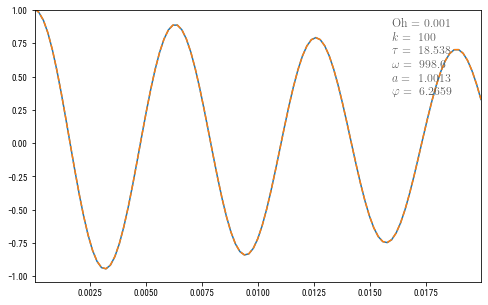

  0%|          | 0/1800 [00:00<?, ?it/s]

frame =  0
new line?  True
Oh =  0.001
k =  100.0
5.469315052032471
params =  [ 18.53828494 998.59967954   1.00133567   6.2658584 ]
frame =  0
new line?  True
Oh =  0.001
k =  100.0
5.302728891372681
params =  [ 18.53828494 998.59967954   1.00133567   6.2658584 ]
frame =  1
new line?  False
Oh =  0.0011689518164985776
k =  100.0
5.296814918518066
params =  [ 21.53020153 998.21912667   1.00167457   6.26317337]
frame =  2
new line?  False
Oh =  0.0013664483492953259
k =  100.0
5.277780055999756
params =  [ 24.99012812 997.73899984   1.00209778   6.26009732]
frame =  3
new line?  False
Oh =  0.001597312280060254
k =  100.0
5.3311989307403564
params =  [ 28.98698164 997.13335906   1.0026255    6.25658055]
frame =  4
new line?  False
Oh =  0.0018671810912919207
k =  100.0
5.299274921417236
params =  [ 33.5984966  996.36955839   1.0032824    6.25256931]
frame =  5
new line?  False
Oh =  0.0021826447283974874
k =  100.0
5.272986173629761
params =  [ 38.9118836  995.40653742   1.00409833   6.2

frame =  55
new line?  False
Oh =  5.3556669177068965
k =  100.0
5.723721981048584
params =  [9.33872860e+00 5.43415729e-04 1.58551803e+00 5.39496141e+00]
frame =  56
new line?  False
Oh =  6.260516572014821
k =  100.0
6.19451379776001
params =  [7.98868784e+00 4.61720509e-04 1.57777050e+00 5.39893097e+00]
frame =  57
new line?  False
Oh =  7.318242219076174
k =  100.0
5.6456451416015625
params =  [6.83388178e+00 3.94717568e-04 1.57120467e+00 5.40233934e+00]
frame =  58
new line?  False
Oh =  8.554672535565684
k =  100.0
6.679174900054932
params =  [5.84604964e+00 3.37496401e-04 1.56564604e+00 5.40525726e+00]
frame =  59
new line?  False
Oh =  10.0
k =  100.0
6.228301048278809
params =  [5.00123469e+00 4.56592303e-04 1.56095514e+00 5.40774316e+00]
frame =  60
new line?  True
Oh =  0.001
k =  72.7895384398315
5.7603209018707275
params =  [  9.88177845 620.36503255   1.00106038   6.2682361 ]
frame =  61
new line?  False
Oh =  0.0011689518164985776
k =  72.7895384398315
5.791011095046997


frame =  107
new line?  False
Oh =  1.536174946671828
k =  72.7895384398315
4.904300212860107
params =  [23.95629502  0.14991861  1.74777992  5.32289958]
frame =  108
new line?  False
Oh =  1.795714494371641
k =  72.7895384398315
4.8572211265563965
params =  [20.42991085  0.09242298  1.71705487  5.33512841]
frame =  109
new line?  False
Oh =  2.0991037201085545
k =  72.7895384398315
5.099594831466675
params =  [17.4352239   0.05471768  1.69060778  5.34613365]
frame =  110
new line?  False
Oh =  2.4537511066398165
k =  72.7895384398315
5.200270891189575
params =  [14.888339    0.03069024  1.66779475  5.35600938]
frame =  111
new line?  False
Oh =  2.868316813342012
k =  72.7895384398315
4.85774302482605
params =  [12.71972963  0.01600733  1.64815396  5.36481422]
frame =  112
new line?  False
Oh =  3.3529241492495565
k =  72.7895384398315
4.826514959335327
params =  [1.08714014e+01 7.58412024e-03 1.63126850e+00 5.37262056e+00]
frame =  113
new line?  False
Oh =  3.919406774847221
k =  72

frame =  158
new line?  False
Oh =  0.376939097538836
k =  52.98316906283707
6.028619050979614
params =  [81.80489791  6.79020598  1.97381013  5.25665834]
frame =  159
new line?  False
Oh =  0.44062364277735727
k =  52.98316906283707
5.759700059890747
params =  [67.82782412  4.28909467  1.98634306  5.25051989]
frame =  160
new line?  False
Oh =  0.5150678076168121
k =  52.98316906283707
5.767009973526001
params =  [56.55805508  2.78993358  1.96660559  5.25446941]
frame =  161
new line?  False
Oh =  0.6020894493336132
k =  52.98316906283707
5.5914812088012695
params =  [47.40967771  1.83318404  1.94624977  5.25902485]
frame =  162
new line?  False
Oh =  0.7038135554931555
k =  52.98316906283707
6.008791923522949
params =  [39.92354474  1.1864613   1.96714944  5.25114236]
frame =  163
new line?  False
Oh =  0.8227241341700465
k =  52.98316906283707
5.892313241958618
params =  [33.71237146  0.78363412  1.94755114  5.25598589]
frame =  164
new line?  False
Oh =  0.9617248711152965
k =  52.

5.569854021072388
params =  [101.59936225 154.57171094   1.11017129   5.93374737]
frame =  210
new line?  False
Oh =  0.10811807510766078
k =  38.56620421163472
5.544490098953247
params =  [110.09047665 144.31840186   1.14385373   5.84042849]
frame =  211
new line?  False
Oh =  0.12638482029342984
k =  38.56620421163472
5.405771017074585
params =  [120.68973986 132.70492137   1.21018015   5.70974245]
frame =  212
new line?  False
Oh =  0.1477377652598511
k =  38.56620421163472
5.390990972518921
params =  [134.07070126 116.40147649   1.35532116   5.55356055]
frame =  213
new line?  False
Oh =  0.17269832906594343
k =  38.56620421163472
5.439980983734131
params =  [150.85309436  91.60108583   1.70873846   5.34234745]
frame =  214
new line?  False
Oh =  0.2018760254679039
k =  38.56620421163472
5.451542854309082
params =  [142.63137405  57.2649887    2.           5.24698487]
frame =  215
new line?  False
Oh =  0.23598334667821938
k =  38.56620421163472
5.648951053619385
params =  [117.060

frame =  261
new line?  False
Oh =  0.02652948464431896
k =  28.072162039411772
5.549958944320679
params =  [ 29.38520435 138.28538795   1.04470794   6.13455172]
frame =  262
new line?  False
Oh =  0.031011689265747787
k =  28.072162039411772
5.84542179107666
params =  [ 32.94550725 135.66857591   1.05248334   6.12283224]
frame =  263
new line?  False
Oh =  0.036251170499885334
k =  28.072162039411772
6.265594244003296
params =  [ 36.66430723 132.47749597   1.06035678   6.11218513]
frame =  264
new line?  False
Oh =  0.04237587160604064
k =  28.072162039411772
5.5911102294921875
params =  [ 40.48140571 128.65636009   1.06846196   6.10267233]
frame =  265
new line?  False
Oh =  0.0495353520895917
k =  28.072162039411772
5.275041103363037
params =  [ 44.3025861  124.11735011   1.07640135   6.0956941 ]
frame =  266
new line?  False
Oh =  0.05790443980602486
k =  28.072162039411772
5.836134910583496
params =  [ 47.98130974 118.92814875   1.08247635   6.08904009]
frame =  267
new line?  Fal

frame =  313
new line?  False
Oh =  0.007609496685459876
k =  20.433597178569418
5.302911996841431
params =  [ 5.48241286 91.63489956  1.00773224  6.23105479]
frame =  314
new line?  False
Oh =  0.008895134973108237
k =  20.433597178569418
5.3587610721588135
params =  [ 6.32199632 91.41550257  1.00956971  6.22376336]
frame =  315
new line?  False
Oh =  0.0103979841848149
k =  20.433597178569418
5.283766984939575
params =  [ 7.27901494 91.13962968  1.01179794  6.2156358 ]
frame =  316
new line?  False
Oh =  0.012154742500762865
k =  20.433597178569418
5.3052637577056885
params =  [ 8.36601668 90.79324264  1.01447506  6.20662427]
frame =  317
new line?  False
Oh =  0.014208308325339224
k =  20.433597178569418
5.3839271068573
params =  [ 9.59540075 90.35924563  1.01765958  6.19668239]
frame =  318
new line?  False
Oh =  0.016608827826277157
k =  20.433597178569418
5.2913641929626465
params =  [10.97887039 89.81705488  1.02141772  6.1857639 ]
frame =  319
new line?  False
Oh =  0.019414919

frame =  365
new line?  False
Oh =  0.0021826447283974874
k =  14.873521072935118
5.3689210414886475
params =  [ 0.90106057 57.42677281  1.00103655  6.26845224]
frame =  366
new line?  False
Oh =  0.0025514065200312875
k =  14.873521072935118
5.376161098480225
params =  [ 1.04711006 57.40990369  1.00130057  6.26615056]
frame =  367
new line?  False
Oh =  0.002982471286216891
k =  14.873521072935118
5.338937282562256
params =  [ 1.21618479 57.38861639  1.00163071  6.26350843]
frame =  368
new line?  False
Oh =  0.0034863652276780842
k =  14.873521072935118
5.293133735656738
params =  [ 1.41173009 57.3617586   1.00204303  6.26048085]
frame =  369
new line?  False
Oh =  0.004075392965871778
k =  14.873521072935118
5.374263048171997
params =  [ 1.63765102 57.32787889  1.00255728  6.25701861]
frame =  370
new line?  False
Oh =  0.004763938010401341
k =  14.873521072935118
5.269057989120483
params =  [ 1.89835469 57.28515051  1.00319755  6.25306841]
frame =  371
new line?  False
Oh =  0.0055

frame =  417
new line?  False
Oh =  7.318242219076174
k =  14.873521072935118
5.061638832092285
params =  [1.02224832e+00 7.60926324e-04 1.63128044e+00 5.37262594e+00]
frame =  418
new line?  False
Oh =  8.554672535565684
k =  14.873521072935118
5.3693671226501465
params =  [8.73961042e-01 3.21457836e-04 1.61680651e+00 5.37949763e+00]
frame =  419
new line?  False
Oh =  10.0
k =  14.873521072935118
5.144163131713867
params =  [7.47375366e-01 1.18351855e-04 1.60441336e+00 5.38552204e+00]
frame =  420
new line?  True
Oh =  0.001
k =  10.826367338740546
5.204304933547974
params =  [ 0.2246423  35.76432992  1.00026097  6.27714394]
frame =  421
new line?  False
Oh =  0.0011689518164985776
k =  10.826367338740546
5.491591930389404
params =  [ 0.26166519 35.7617555   1.00032838  6.27617008]
frame =  422
new line?  False
Oh =  0.0013664483492953259
k =  10.826367338740546
5.303776025772095
params =  [ 0.30469676 35.75850385  1.00041307  6.27504409]
frame =  423
new line?  False
Oh =  0.0015973

frame =  469
new line?  False
Oh =  2.0991037201085545
k =  10.826367338740546
5.25503396987915
params =  [2.69607628 0.05124751 1.88948363 5.273769  ]
frame =  470
new line?  False
Oh =  2.4537511066398165
k =  10.826367338740546
5.2361931800842285
params =  [2.28727856 0.03343647 1.88125759 5.27569579]
frame =  471
new line?  False
Oh =  2.868316813342012
k =  10.826367338740546
5.19654107093811
params =  [1.94347862 0.02206815 1.83520301 5.29094572]
frame =  472
new line?  False
Oh =  3.3529241492495565
k =  10.826367338740546
5.2684290409088135
params =  [1.65373743 0.01438969 1.78936274 5.30721428]
frame =  473
new line?  False
Oh =  3.919406774847221
k =  10.826367338740546
5.3803629875183105
params =  [1.40884678 0.00917682 1.75156206 5.32144005]
frame =  474
new line?  False
Oh =  4.581597669054491
k =  10.826367338740546
5.37007999420166
params =  [1.20133705 0.00568215 1.72033371 5.33380061]
frame =  475
new line?  False
Oh =  5.3556669177068965
k =  10.826367338740546
5.0984

5.1687211990356445
params =  [9.04687574 1.91900292 2.         5.25479403]
frame =  522
new line?  False
Oh =  0.7038135554931555
k =  7.880462815669913
5.585649013519287
params =  [7.30022402 1.12005029 2.         5.25377822]
frame =  523
new line?  False
Oh =  0.8227241341700465
k =  7.880462815669913
5.123312950134277
params =  [5.93777092 0.67356623 1.99999997 5.25158169]
frame =  524
new line?  False
Oh =  0.9617248711152965
k =  7.880462815669913
5.118875026702881
params =  [4.87473617 0.41684573 2.         5.24911536]
frame =  525
new line?  False
Oh =  1.1242100350620863
k =  7.880462815669913
5.100442886352539
params =  [4.03499427 0.26403462 1.99865809 5.24717863]
frame =  526
new line?  False
Oh =  1.3141473626117568
k =  7.880462815669913
5.198040008544922
params =  [3.36104723 0.17165912 1.97531237 5.25210749]
frame =  527
new line?  False
Oh =  1.536174946671828
k =  7.880462815669913
5.196379899978638
params =  [2.8149651  0.11306772 1.94721237 5.25897174]
frame =  528
n

frame =  574
new line?  False
Oh =  0.2018760254679039
k =  5.736152510448679
5.174178123474121
params =  [5.43713781 9.64923332 1.09332264 6.01360157]
frame =  575
new line?  False
Oh =  0.23598334667821938
k =  5.736152510448679
5.191152811050415
params =  [5.83265911 9.11961356 1.10606978 5.94647702]
frame =  576
new line?  False
Oh =  0.2758531617629184
k =  5.736152510448679
5.16983699798584
params =  [6.31625356 8.54242957 1.13619527 5.85645015]
frame =  577
new line?  False
Oh =  0.32245905452963947
k =  5.736152510448679
5.149999141693115
params =  [6.91701419 7.89451178 1.19507562 5.73119631]
frame =  578
new line?  False
Oh =  0.376939097538836
k =  5.736152510448679
5.403425931930542
params =  [7.67925348 6.9981627  1.32383826 5.58113992]
frame =  579
new line?  False
Oh =  0.44062364277735727
k =  5.736152510448679
5.281818151473999
params =  [8.63454398 5.66367034 1.62210752 5.38205553]
frame =  580
new line?  False
Oh =  0.5150678076168121
k =  5.736152510448679
5.1808440

4.838915109634399
params =  [1.67820911 8.18631875 1.04262675 6.13780296]
frame =  628
new line?  False
Oh =  0.07912342618981323
k =  4.175318936560401
4.916957139968872
params =  [1.88479263 8.04083254 1.05021879 6.12582206]
frame =  629
new line?  False
Oh =  0.09249147277217336
k =  4.175318936560401
5.025733232498169
params =  [2.10159927 7.86261256 1.05789164 6.1149558 ]
frame =  630
new line?  False
Oh =  0.10811807510766078
k =  4.175318936560401
4.86149001121521
params =  [2.32489779 7.64899698 1.06560525 6.10493068]
frame =  631
new line?  False
Oh =  0.12638482029342984
k =  4.175318936560401
5.083285808563232
params =  [2.55005592 7.39585017 1.07315444 6.0967229 ]
frame =  632
new line?  False
Oh =  0.1477377652598511
k =  4.175318936560401
5.089864015579224
params =  [2.76900806 7.10559467 1.07887639 6.08880899]
frame =  633
new line?  False
Oh =  0.17269832906594343
k =  4.175318936560401
5.11861777305603
params =  [2.98058414 6.79635437 1.08223208 6.07339183]
frame =  63

frame =  681
new line?  False
Oh =  0.02652948464431896
k =  3.039195382313198
5.38980507850647
params =  [0.41888126 5.4888867  1.01077892 6.21817159]
frame =  682
new line?  False
Oh =  0.031011689265747787
k =  3.039195382313198
5.347121953964233
params =  [0.48163542 5.4698901  1.01321705 6.20933095]
frame =  683
new line?  False
Oh =  0.036251170499885334
k =  3.039195382313198
5.385792970657349
params =  [0.55276329 5.44612157 1.01613799 6.1995436 ]
frame =  684
new line?  False
Oh =  0.04237587160604064
k =  3.039195382313198
5.401623964309692
params =  [0.63300185 5.41643078 1.01960459 6.18878391]
frame =  685
new line?  False
Oh =  0.0495353520895917
k =  3.039195382313198
5.316118955612183
params =  [0.72300181 5.37943693 1.0236807  6.17705287]
frame =  686
new line?  False
Oh =  0.05790443980602486
k =  3.039195382313198
5.313564777374268
params =  [0.82327419 5.33349022 1.02843764 6.16441386]
frame =  687
new line?  False
Oh =  0.06768750009458535
k =  3.039195382313198
5.3

5.3230390548706055
params =  [0.08794208 3.5545669  1.00220986 6.26107579]
frame =  735
new line?  False
Oh =  0.0103979841848149
k =  2.2122162910704493
5.358474969863892
params =  [0.10157064 3.55229923 1.00266215 6.25770384]
frame =  736
new line?  False
Oh =  0.012154742500762865
k =  2.2122162910704493
5.315913200378418
params =  [0.11727978 3.54954088 1.00321602 6.25384347]
frame =  737
new line?  False
Oh =  0.014208308325339224
k =  2.2122162910704493
5.448720932006836
params =  [0.13536986 3.5461737  1.00389451 6.2494319 ]
frame =  738
new line?  False
Oh =  0.016608827826277157
k =  2.2122162910704493
5.39344596862793
params =  [0.15617875 3.54204948 1.00472605 6.24440171]
frame =  739
new line?  False
Oh =  0.019414919457438805
k =  2.2122162910704493
5.2388999462127686
params =  [0.18008322 3.53698113 1.005745   6.23868358]
frame =  740
new line?  False
Oh =  0.022695105366946685
k =  2.2122162910704493
5.2758259773254395
params =  [0.20749705 3.53073265 1.00699016 6.232210

5.3268067836761475
params =  [0.02298297 2.30294658 1.00121839 6.27532109]
frame =  788
new line?  False
Oh =  0.0034863652276780842
k =  1.6102620275609392
5.394586801528931
params =  [0.02615773 2.30218487 1.00135233 6.27414409]
frame =  789
new line?  False
Oh =  0.004075392965871778
k =  1.6102620275609392
5.161658763885498
params =  [0.02980145 2.30133574 1.00150566 6.27278688]
frame =  790
new line?  False
Oh =  0.004763938010401341
k =  1.6102620275609392
5.341233015060425
params =  [0.03398524 2.30038551 1.00168198 6.27122215]
frame =  791
new line?  False
Oh =  0.005568813990945267
k =  1.6102620275609392
5.357259035110474
params =  [0.03879088 2.29931773 1.00188568 6.26941863]
frame =  792
new line?  False
Oh =  0.00650967523045817
k =  1.6102620275609392
5.3194899559021
params =  [0.04431229 2.29811253 1.00212209 6.26734061]
frame =  793
new line?  False
Oh =  0.007609496685459876
k =  1.6102620275609392
5.282344102859497
params =  [0.05065725 2.2967459  1.00239769 6.2649471

frame =  840
new line?  True
Oh =  0.001
k =  1.1721022975334805
5.455168962478638
params =  [0.00913857 1.50869412 1.0012945  6.27956912]
frame =  841
new line?  False
Oh =  0.0011689518164985776
k =  1.1721022975334805
5.543482780456543
params =  [0.01013808 1.50817339 1.00140261 6.27910582]
frame =  842
new line?  False
Oh =  0.0013664483492953259
k =  1.1721022975334805
5.380135774612427
params =  [0.01126156 1.50760861 1.0015202  6.27857681]
frame =  843
new line?  False
Oh =  0.001597312280060254
k =  1.1721022975334805
5.380964040756226
params =  [0.01252611 1.50699576 1.00164819 6.27797209]
frame =  844
new line?  False
Oh =  0.0018671810912919207
k =  1.1721022975334805
5.406556129455566
params =  [0.01395137 1.50633037 1.0017876  6.27728012]
frame =  845
new line?  False
Oh =  0.0021826447283974874
k =  1.1721022975334805
5.367233037948608
params =  [0.0155599  1.50560746 1.00193959 6.2764876 ]
frame =  846
new line?  False
Oh =  0.0025514065200312875
k =  1.1721022975334805


frame =  893
new line?  False
Oh =  3.919406774847221
k =  1.1721022975334805
5.26897406578064
params =  [8.20460785e-02 6.42953392e-04 1.78214411e+00 5.30994908e+00]
frame =  894
new line?  False
Oh =  4.581597669054491
k =  1.1721022975334805
5.466453790664673
params =  [6.99077576e-02 3.99521329e-04 1.74645981e+00 5.32346912e+00]
frame =  895
new line?  False
Oh =  5.3556669177068965
k =  1.1721022975334805
5.270008087158203
params =  [5.96187081e-02 2.38117857e-04 1.71583106e+00 5.33566986e+00]
frame =  896
new line?  False
Oh =  6.260516572014821
k =  1.1721022975334805
5.352587938308716
params =  [5.08817686e-02 1.34109854e-04 1.68944362e+00 5.34666021e+00]
frame =  897
new line?  False
Oh =  7.318242219076174
k =  1.1721022975334805
5.6640989780426025
params =  [4.34524018e-02 7.00175073e-05 1.66669867e+00 5.35651585e+00]
frame =  898
new line?  False
Oh =  8.554672535565684
k =  1.1721022975334805
5.333600044250488
params =  [3.71272961e-02 3.30030698e-05 1.64711987e+00 5.36530

frame =  946
new line?  False
Oh =  1.3141473626117568
k =  0.8531678524172805
4.815982103347778
params =  [0.15012328 0.00590577 1.93893964 5.26187073]
frame =  947
new line?  False
Oh =  1.536174946671828
k =  0.8531678524172805
4.803191900253296
params =  [1.26383517e-01 3.77461371e-03 1.97853238e+00 5.24813153e+00]
frame =  948
new line?  False
Oh =  1.795714494371641
k =  0.8531678524172805
5.570224761962891
params =  [1.06671403e-01 2.48877102e-03 1.95378048e+00 5.25439863e+00]
frame =  949
new line?  False
Oh =  2.0991037201085545
k =  0.8531678524172805
4.977313995361328
params =  [9.02636544e-02 1.66465591e-03 1.89577415e+00 5.27185486e+00]
frame =  950
new line?  False
Oh =  2.4537511066398165
k =  0.8531678524172805
4.875046253204346
params =  [7.65802391e-02 1.07138473e-03 1.90190596e+00 5.26898037e+00]
frame =  951
new line?  False
Oh =  2.868316813342012
k =  0.8531678524172805
4.870979070663452
params =  [6.50660393e-02 7.03367886e-04 1.84924904e+00 5.28609014e+00]
frame

4.9514360427856445
params =  [0.40547462 0.11966186 2.         5.25567825]
frame =  999
new line?  False
Oh =  0.44062364277735727
k =  0.6210169418915616
5.009602069854736
params =  [0.3261062  0.06795754 2.         5.2567707 ]
frame =  1000
new line?  False
Oh =  0.5150678076168121
k =  0.6210169418915616
4.95146107673645
params =  [0.2628487  0.03963524 2.         5.25516085]
frame =  1001
new line?  False
Oh =  0.6020894493336132
k =  0.6210169418915616
4.928709030151367
params =  [0.21376339 0.02389163 1.99999996 5.25258459]
frame =  1002
new line?  False
Oh =  0.7038135554931555
k =  0.6210169418915616
4.930429935455322
params =  [0.17550362 0.01481796 2.         5.24986682]
frame =  1003
new line?  False
Oh =  0.8227241341700465
k =  0.6210169418915616
5.026129245758057
params =  [0.14527734 0.00938877 1.99999997 5.24735536]
frame =  1004
new line?  False
Oh =  0.9617248711152965
k =  0.6210169418915616
5.070418834686279
params =  [0.12105719 0.00603584 1.99999473 5.24517459]
fr

frame =  1050
new line?  False
Oh =  0.10811807510766078
k =  0.45203536563602453
4.919550895690918
params =  [0.18094154 0.40555596 1.0890693  5.87840956]
frame =  1051
new line?  False
Oh =  0.12638482029342984
k =  0.45203536563602453
4.924615144729614
params =  [0.21031067 0.39094431 1.12892492 5.80203328]
frame =  1052
new line?  False
Oh =  0.1477377652598511
k =  0.45203536563602453
4.891874074935913
params =  [0.24480585 0.37017766 1.19162757 5.70899489]
frame =  1053
new line?  False
Oh =  0.17269832906594343
k =  0.45203536563602453
4.952445030212402
params =  [0.28527695 0.33985926 1.29747181 5.59282762]
frame =  1054
new line?  False
Oh =  0.2018760254679039
k =  0.45203536563602453
4.878983974456787
params =  [0.33271943 0.29349113 1.50213061 5.44108642]
frame =  1055
new line?  False
Oh =  0.23598334667821938
k =  0.45203536563602453
5.102771043777466
params =  [0.38268904 0.21483136 2.         5.23734442]
frame =  1056
new line?  False
Oh =  0.2758531617629184
k =  0.452

4.855716943740845
params =  [0.04590015 0.3118907  1.0152609  6.17430906]
frame =  1102
new line?  False
Oh =  0.031011689265747787
k =  0.32903445623126676
4.830424785614014
params =  [0.05169351 0.31019331 1.0160818  6.15320994]
frame =  1103
new line?  False
Oh =  0.036251170499885334
k =  0.32903445623126676
4.858374834060669
params =  [0.05857685 0.3083212  1.01813498 6.12784976]
frame =  1104
new line?  False
Oh =  0.04237587160604064
k =  0.32903445623126676
4.794074773788452
params =  [0.06676643 0.30613661 1.02197314 6.09771939]
frame =  1105
new line?  False
Oh =  0.0495353520895917
k =  0.32903445623126676
4.79202675819397
params =  [0.07650098 0.30344745 1.02828373 6.06217261]
frame =  1106
new line?  False
Oh =  0.05790443980602486
k =  0.32903445623126676
4.806594133377075
params =  [0.08804748 0.29999031 1.03800395 6.02035026]
frame =  1107
new line?  False
Oh =  0.06768750009458535
k =  0.32903445623126676
4.81151008605957
params =  [0.10170862 0.29540143 1.05251734 5.9

4.8974549770355225
params =  [0.01600318 0.23058656 1.01514731 6.24571265]
frame =  1153
new line?  False
Oh =  0.007609496685459876
k =  0.2395026619987486
4.91877293586731
params =  [0.01754792 0.22955635 1.01588847 6.24113574]
frame =  1154
new line?  False
Oh =  0.008895134973108237
k =  0.2395026619987486
4.882927894592285
params =  [0.01925466 0.22846747 1.01640256 6.23579328]
frame =  1155
new line?  False
Oh =  0.0103979841848149
k =  0.2395026619987486
4.922582149505615
params =  [0.02114776 0.22733619 1.01657411 6.22931206]
frame =  1156
new line?  False
Oh =  0.012154742500762865
k =  0.2395026619987486
4.946919918060303
params =  [0.02326818 0.22618515 1.01636379 6.22117292]
frame =  1157
new line?  False
Oh =  0.014208308325339224
k =  0.2395026619987486
4.921133041381836
params =  [0.02567928 0.22503557 1.01586317 6.21078616]
frame =  1158
new line?  False
Oh =  0.016608827826277157
k =  0.2395026619987486
5.101078987121582
params =  [0.02846822 0.22389719 1.01530709 6.19

5.061902046203613
params =  [6.26150632e-03 1.70256089e-01 1.00987752e+00 6.26579033e+00]
frame =  1204
new line?  False
Oh =  0.0018671810912919207
k =  0.17433288221999874
4.90813684463501
params =  [0.00681855 0.16979057 1.01060427 6.2639569 ]
frame =  1205
new line?  False
Oh =  0.0021826447283974874
k =  0.17433288221999874
4.925622224807739
params =  [0.00742945 0.16928943 1.01136757 6.26189009]
frame =  1206
new line?  False
Oh =  0.0025514065200312875
k =  0.17433288221999874
4.938325881958008
params =  [0.00810038 0.16875054 1.01216725 6.25955009]
frame =  1207
new line?  False
Oh =  0.002982471286216891
k =  0.17433288221999874
4.913335084915161
params =  [0.00883853 0.16817147 1.01300638 6.25689618]
frame =  1208
new line?  False
Oh =  0.0034863652276780842
k =  0.17433288221999874
4.899787187576294
params =  [0.00965186 0.16754917 1.01388691 6.25389613]
frame =  1209
new line?  False
Oh =  0.004075392965871778
k =  0.17433288221999874
4.960687160491943
params =  [0.01054846

4.85461688041687
params =  [2.16081660e-03 1.25374164e-07 1.58771202e+00 5.39387820e+00]
frame =  1255
new line?  False
Oh =  5.3556669177068965
k =  0.17433288221999874
4.857057094573975
params =  [1.84841649e-03 1.06273938e-07 1.57963852e+00 5.39799144e+00]
frame =  1256
new line?  False
Oh =  6.260516572014821
k =  0.17433288221999874
4.8446009159088135
params =  [1.58120309e-03 9.07923834e-08 1.57279371e+00 5.40152740e+00]
frame =  1257
new line?  False
Oh =  7.318242219076174
k =  0.17433288221999874
4.814768075942993
params =  [1.35268657e-03 1.22925911e-07 1.56699581e+00 5.40455825e+00]
frame =  1258
new line?  False
Oh =  8.554672535565684
k =  0.17433288221999874
4.83132004737854
params =  [1.15715651e-03 1.05121042e-07 1.56212561e+00 5.40712981e+00]
frame =  1259
new line?  False
Oh =  10.0
k =  0.17433288221999874
4.813153028488159
params =  [9.89895277e-04 8.98568116e-08 1.55811134e+00 5.40926716e+00]
frame =  1260
new line?  True
Oh =  0.001
k =  0.12689610031679222
4.9023

frame =  1305
new line?  False
Oh =  1.1242100350620863
k =  0.12689610031679222
4.680716037750244
params =  [4.74916418e-03 1.90901624e-05 1.74199262e+00 5.32492599e+00]
frame =  1306
new line?  False
Oh =  1.3141473626117568
k =  0.12689610031679222
4.703336954116821
params =  [4.05299044e-03 1.08189552e-05 1.71165785e+00 5.33715440e+00]
frame =  1307
new line?  False
Oh =  1.536174946671828
k =  0.12689610031679222
4.6639111042022705
params =  [3.46106727e-03 5.69056502e-06 1.68556967e+00 5.34814144e+00]
frame =  1308
new line?  False
Oh =  1.795714494371641
k =  0.12689610031679222
5.151565074920654
params =  [2.95716770e-03 2.70733114e-06 1.66314665e+00 5.35795799e+00]
frame =  1309
new line?  False
Oh =  2.0991037201085545
k =  0.12689610031679222
4.9002368450164795
params =  [2.52772247e-03 1.12109924e-06 1.64390389e+00 5.36667510e+00]
frame =  1310
new line?  False
Oh =  2.4537511066398165
k =  0.12689610031679222
4.8907201290130615
params =  [2.16136392e-03 3.89887749e-07 1.62

frame =  1355
new line?  False
Oh =  0.23598334667821938
k =  0.09236708571873865
5.074125051498413
params =  [1.28960061e-02 4.86371236e-04 1.97244739e+00 5.25131504e+00]
frame =  1356
new line?  False
Oh =  0.2758531617629184
k =  0.09236708571873865
4.914677143096924
params =  [1.08503332e-02 3.23380769e-04 1.93060187e+00 5.26278166e+00]
frame =  1357
new line?  False
Oh =  0.32245905452963947
k =  0.09236708571873865
5.079751968383789
params =  [9.16000059e-03 2.15855781e-04 1.88267959e+00 5.27717061e+00]
frame =  1358
new line?  False
Oh =  0.376939097538836
k =  0.09236708571873865
4.694076776504517
params =  [7.75953629e-03 1.36335430e-04 1.93814755e+00 5.25812200e+00]
frame =  1359
new line?  False
Oh =  0.44062364277735727
k =  0.09236708571873865
4.916850805282593
params =  [6.58211241e-03 9.05779240e-05 1.88055056e+00 5.27597920e+00]
frame =  1360
new line?  False
Oh =  0.5150678076168121
k =  0.09236708571873865
4.886676073074341
params =  [5.59348809e-03 5.93870820e-05 1.8

4.940018892288208
params =  [0.05293902 0.03054639 1.98815432 5.23953064]
frame =  1405
new line?  False
Oh =  0.0495353520895917
k =  0.06723357536499334
4.917325735092163
params =  [0.04566265 0.01835948 2.         5.25029006]
frame =  1406
new line?  False
Oh =  0.05790443980602486
k =  0.06723357536499334
5.002148866653442
params =  [0.03723837 0.01042919 2.         5.25607939]
frame =  1407
new line?  False
Oh =  0.06768750009458535
k =  0.06723357536499334
4.908666133880615
params =  [0.02993349 0.00593927 2.         5.25662465]
frame =  1408
new line?  False
Oh =  0.07912342618981323
k =  0.06723357536499334
4.998565196990967
params =  [2.41540559e-02 3.48083824e-03 1.99999995e+00 5.25479749e+00]
frame =  1409
new line?  False
Oh =  0.09249147277217336
k =  0.06723357536499334
4.961593151092529
params =  [1.96717384e-02 2.10786525e-03 2.00000000e+00 5.25216839e+00]
frame =  1410
new line?  False
Oh =  0.10811807510766078
k =  0.06723357536499334
5.00264573097229
params =  [1.617

4.817150831222534
params =  [0.01012373 0.04343244 1.0240282  6.08229797]
frame =  1454
new line?  False
Oh =  0.008895134973108237
k =  0.04893900918477494
4.853693962097168
params =  [0.01162411 0.04301153 1.03191383 6.04371394]
frame =  1455
new line?  False
Oh =  0.0103979841848149
k =  0.04893900918477494
4.860271692276001
params =  [0.01340374 0.04245758 1.04377329 5.99845069]
frame =  1456
new line?  False
Oh =  0.012154742500762865
k =  0.04893900918477494
4.911588191986084
params =  [0.01550791 0.04171011 1.06129287 5.94514216]
frame =  1457
new line?  False
Oh =  0.014208308325339224
k =  0.04893900918477494
4.86544394493103
params =  [0.01798916 0.04068279 1.08722267 5.88192759]
frame =  1458
new line?  False
Oh =  0.016608827826277157
k =  0.04893900918477494
4.928436994552612
params =  [0.02090877 0.03924801 1.12632996 5.8061981 ]
frame =  1459
new line?  False
Oh =  0.019414919457438805
k =  0.04893900918477494
4.833346843719482
params =  [0.02433853 0.03720771 1.18762199

frame =  1503
new line?  False
Oh =  0.001597312280060254
k =  0.03562247890262444
4.755288124084473
params =  [3.06790157e-03 3.30457371e-02 1.01749700e+00 6.23283422e+00]
frame =  1504
new line?  False
Oh =  0.0018671810912919207
k =  0.03562247890262444
4.77749490737915
params =  [3.35633180e-03 3.28718575e-02 1.01699380e+00 6.22517068e+00]
frame =  1505
new line?  False
Oh =  0.0021826447283974874
k =  0.03562247890262444
4.7489399909973145
params =  [3.68456512e-03 3.27016233e-02 1.01616603e+00 6.21515927e+00]
frame =  1506
new line?  False
Oh =  0.0025514065200312875
k =  0.03562247890262444
4.741112232208252
params =  [4.06596954e-03 3.25364416e-02 1.01529005e+00 6.20227675e+00]
frame =  1507
new line?  False
Oh =  0.002982471286216891
k =  0.03562247890262444
4.7651848793029785
params =  [4.51657909e-03 3.23744766e-02 1.01473255e+00 6.18610905e+00]
frame =  1508
new line?  False
Oh =  0.0034863652276780842
k =  0.03562247890262444
4.8022871017456055
params =  [5.05429217e-03 3.

frame =  1552
new line?  False
Oh =  3.3529241492495565
k =  0.03562247890262444
4.726598024368286
params =  [1.26049590e-04 1.82144007e-08 1.51848943e+00 5.43129135e+00]
frame =  1553
new line?  False
Oh =  3.919406774847221
k =  0.03562247890262444
4.650746822357178
params =  [1.07830643e-04 1.55846667e-08 1.50774918e+00 5.43753878e+00]
frame =  1554
new line?  False
Oh =  4.581597669054491
k =  0.03562247890262444
4.7387073040008545
params =  [9.22451620e-05 1.33081854e-08 1.50081455e+00 5.44163847e+00]
frame =  1555
new line?  False
Oh =  5.3556669177068965
k =  0.03562247890262444
4.660476207733154
params =  [7.89124359e-05 1.13498587e-08 1.49618663e+00 5.44440389e+00]
frame =  1556
new line?  False
Oh =  6.260516572014821
k =  0.03562247890262444
4.711152076721191
params =  [6.75068145e-05 9.67092880e-09 1.49302732e+00 5.44630547e+00]
frame =  1557
new line?  False
Oh =  7.318242219076174
k =  0.03562247890262444
4.711878776550293
params =  [5.77497343e-05 8.23346196e-09 1.490840

frame =  1601
new line?  False
Oh =  0.6020894493336132
k =  0.02592943797404667
5.560508966445923
params =  [3.72185835e-04 5.62935423e-08 1.60025515e+00 5.38759061e+00]
frame =  1602
new line?  False
Oh =  0.7038135554931555
k =  0.02592943797404667
5.173886060714722
params =  [3.18369223e-04 4.66382253e-08 1.59031446e+00 5.39255244e+00]
frame =  1603
new line?  False
Oh =  0.8227241341700465
k =  0.02592943797404667
5.153517961502075
params =  [2.72340696e-04 3.97993577e-08 1.58188499e+00 5.39683102e+00]
frame =  1604
new line?  False
Oh =  0.9617248711152965
k =  0.02592943797404667
5.1696319580078125
params =  [2.32969906e-04 3.39918786e-08 1.57474487e+00 5.40050748e+00]
frame =  1605
new line?  False
Oh =  1.1242100350620863
k =  0.02592943797404667
5.166633129119873
params =  [1.99292656e-04 2.90191153e-08 1.56870621e+00 5.40365506e+00]
frame =  1606
new line?  False
Oh =  1.3141473626117568
k =  0.02592943797404667
5.133642911911011
params =  [1.70484865e-04 2.47621591e-08 1.56

5.056797981262207
params =  [1.31657408e-03 1.77698938e-05 1.85958502e+00 5.28303809e+00]
frame =  1650
new line?  False
Oh =  0.10811807510766078
k =  0.018873918221350976
5.123877048492432
params =  [1.11906465e-03 1.15894209e-05 1.81545094e+00 5.29803247e+00]
frame =  1651
new line?  False
Oh =  0.12638482029342984
k =  0.018873918221350976
4.918643951416016
params =  [9.52492427e-04 7.41903436e-06 1.77325885e+00 5.31333790e+00]
frame =  1652
new line?  False
Oh =  0.1477377652598511
k =  0.018873918221350976
5.181823968887329
params =  [8.11616446e-04 4.60449195e-06 1.73896675e+00 5.32647090e+00]
frame =  1653
new line?  False
Oh =  0.17269832906594343
k =  0.018873918221350976
5.333807945251465
params =  [6.92189079e-04 2.74045452e-06 1.70947689e+00 5.33832892e+00]
frame =  1654
new line?  False
Oh =  0.2018760254679039
k =  0.018873918221350976
5.369915008544922
params =  [5.90768542e-04 1.54088526e-06 1.68404652e+00 5.34900792e+00]
frame =  1655
new line?  False
Oh =  0.23598334

frame =  1698
new line?  False
Oh =  0.016608827826277157
k =  0.013738237958832637
4.766297101974487
params =  [4.78553934e-03 6.61069877e-04 1.99999997e+00 5.25445828e+00]
frame =  1699
new line?  False
Oh =  0.019414919457438805
k =  0.013738237958832637
4.771414041519165
params =  [3.90273881e-03 4.02009908e-04 2.00000000e+00 5.25178901e+00]
frame =  1700
new line?  False
Oh =  0.022695105366946685
k =  0.013738237958832637
4.84907603263855
params =  [3.21224798e-03 2.51049521e-04 2.00000000e+00 5.24911075e+00]
frame =  1701
new line?  False
Oh =  0.02652948464431896
k =  0.013738237958832637
5.292394638061523
params =  [2.66447057e-03 1.59835784e-04 1.99999991e+00 5.24668921e+00]
frame =  1702
new line?  False
Oh =  0.031011689265747787
k =  0.013738237958832637
5.172616958618164
params =  [2.22388932e-03 1.03070064e-04 2.00000000e+00 5.24460874e+00]
frame =  1703
new line?  False
Oh =  0.036251170499885334
k =  0.013738237958832637
5.329503774642944
params =  [1.86452412e-03 6.80

4.906347751617432
params =  [3.23849485e-03 8.48634331e-03 1.06465411e+00 5.93608008e+00]
frame =  1747
new line?  False
Oh =  0.002982471286216891
k =  0.01
4.865418910980225
params =  [3.75796232e-03 8.26578243e-03 1.09223798e+00 5.87112782e+00]
frame =  1748
new line?  False
Oh =  0.0034863652276780842
k =  0.01
4.887267827987671
params =  [4.36902992e-03 7.95694392e-03 1.13402622e+00 5.79316456e+00]
frame =  1749
new line?  False
Oh =  0.004075392965871778
k =  0.01
4.8752710819244385
params =  [5.08671009e-03 7.51632296e-03 1.20005865e+00 5.69804664e+00]
frame =  1750
new line?  False
Oh =  0.004763938010401341
k =  0.01
4.8815131187438965
params =  [0.00592861 0.00687018 1.31259613 5.57889982]
frame =  1751
new line?  False
Oh =  0.005568813990945267
k =  0.01
4.868591785430908
params =  [0.00691537 0.00587461 1.53479983 5.4222002 ]
frame =  1752
new line?  False
Oh =  0.00650967523045817
k =  0.01
5.067466974258423
params =  [7.72825605e-03 4.18456683e-03 2.00000000e+00 5.239006

frame =  1799
new line?  False
Oh =  10.0
k =  0.01
4.750895738601685
params =  [3.33347815e-06 3.72462886e-10 1.48938746e+00 5.44850825e+00]


<Figure size 432x288 with 0 Axes>

In [40]:
k_, Oh_ = scanner_list[0]
print("Oh = ", Oh_)
print("k = ", k_)
plt.rcParams.update({"text.usetex": False})
params, sampled_t, sampled_eta = om_numerical(Oh_, 1., k_)
params_leftmost = params
eta_fit = better_sinusoid(sampled_t, *params)
fig = plt.figure(figsize=(8, 5))
ax = plt.subplot(1, 1, 1)
(line1,) = plt.plot(sampled_t, sampled_eta)
(line2,) = plt.plot(sampled_t, eta_fit, '--')
font = matplotlib.font_manager.FontProperties(
    family="Roboto Condensed", weight="regular", size=9
)
ax = plt.gca()
ax.set_ylim([None,1.0])
for label in ax.get_xticklabels():
    label.set_size(9)
    label.set_fontproperties(font)
for label in ax.get_yticklabels():
    label.set_size(9)
    label.set_fontproperties(font)
bidule = 149986.001432
textOh = ax.text(
    0.8,
    0.95,
    r"$$\mathrm{{Oh =\ }} {0:.5g}$$".format(Oh_),
    size=12,
    color=".35",
    usetex= True,
    horizontalalignment="left",
    verticalalignment="center", transform=ax.transAxes
)
textk = ax.text(
    0.8,
    0.9,
    r"$$k =\ {0:.5g}$$".format(k_),
    size=12,
    color=".35",
    usetex= True,
    horizontalalignment="left",
    verticalalignment="center", transform=ax.transAxes
)
texttau = ax.text(
    0.8,
    0.85,
    r"$$\tau =\ {0:.5g}$$".format(params[0]),
    size=12,
    color=".35",
    usetex= True,
    horizontalalignment="left",
    verticalalignment="center", transform=ax.transAxes
)
textomega = ax.text(
    0.8,
    0.8,
    r"$$\omega =\ {0:.5g}$$".format(params[1]),
    size=12,
    color=".35",
    usetex= True,
    horizontalalignment="left",
    verticalalignment="center", transform=ax.transAxes
)
texta = ax.text(
    0.8,
    0.75,
    r"$$a =\ {0:.5g}$$".format(params[2]),
    size=12,
    color=".35",
    usetex= True,
    horizontalalignment="left",
    verticalalignment="center", transform=ax.transAxes
)
textphi = ax.text(
    0.8,
    0.7,
    r"$$\varphi =\ {0:.5g}$$".format(params[3]),
    size=12,
    color=".35",
    usetex= True,
    horizontalalignment="left",
    verticalalignment="center", transform=ax.transAxes
)

def update(frame):
    global params, params_leftmost
    global scanner_list
    global stride # this is the length of a row
    if ((frame % stride) == 0): # this means there is a "carriage return"
        params = params_leftmost        
    k_, Oh_ = scanner_list[frame]
    print("frame = ", frame)
    print("new line? ", ((frame % stride) == 0))
    print("Oh = ", Oh_)
    print("k = ", k_)
    params, sampled_t, sampled_eta = om_numerical(Oh_, 1., k_, params)
    if ((frame % stride) == 0): # this means there is a "carriage return"
        params_leftmost = params    
    print("params = ", params)
    eta_fit = better_sinusoid(sampled_t, *params)
    line1.set_data(sampled_t, sampled_eta)
    line2.set_data(sampled_t, eta_fit)
    textOh.set_text(r"$$\mathrm{{Oh =\ }} {0:.5g}$$".format(Oh_))
    textk.set_text(r"$$k =\ {0:.5g}$$".format(k_))
    texttau.set_text(r"$$\tau =\ {0:.5g}$$".format(params[0]))
    textomega.set_text(r"$$\omega =\ {0:.5g}$$".format(params[1]))
    texta.set_text(r"$$a =\ {0:.5g}$$".format(params[2]))
    textphi.set_text(r"$$\varphi =\ {0:.5g}$$".format(params[3]))
 
    ax.relim()
    ax.autoscale_view(True, True, True)
    #plt.savefig("Oh-%03d.pdf" % frame)

    return line1, line2, textOh, textk, texttau, textomega, texta, textphi, ax

#plt.tight_layout()
ax.autoscale(enable=True, axis='x', tight=True)
plt.savefig("Oh1e-1_k_5e1.png")

plt.show()

plt.tight_layout()
writer = animation.FFMpegWriter(fps=4, bitrate = 10000)
anim = animation.FuncAnimation(fig, update, interval=len(scanner_list), frames=len(scanner_list))
from tqdm.autonotebook import tqdm

bar = tqdm(total=len(scanner_list))
anim.save(
    "blou.mp4",
    writer=writer,
    dpi=300,
    progress_callback=lambda i, n: bar.update(1),
)
bar.close()

In [162]:
print(r"{0:.1e}bla".format(1323.2987632e-7).replace("e-0","e-").replace(".","_")+".png")

1_3e-4bla.png


In [140]:
format(9.0387681E-8, '.6E')

'9.038768E-08'

In [18]:
glou = ("a", "b", "c")

In [19]:
glop = glou

In [20]:
glop

('a', 'b', 'c')

In [177]:
np.array((1,2))

array([1, 2])

In [193]:
def update():
    global x
    x += 1

In [194]:
x = 1

In [196]:
update()

In [197]:
x

2

In [367]:
Oh_

0.001

In [381]:
np.concatenate((np.linspace(0.,1.,2,endpoint=False),np.linspace(1.,2.,3)))

array([0. , 0.5, 1. , 1.5, 2. ])

In [382]:
np.array([1e-4,1e-3])

array([0.0001, 0.001 ])